In [1]:
# =========================
# Figure 4b-lite: LINCS only, MLP only, CP/GE/Early/Late, TopN sweep
# =========================

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn import preprocessing
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.decomposition import PCA
# %matplotlib inline
# Dimension reduction and clustering libraries
# import umap
# import hdbscan
import sys
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sys.path.insert(0, '../utils/') 
from readProfiles import *
from pred_models import *
from saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile

In [26]:
# -------------------------
# 0) USER SETTINGS
# -------------------------
procProf_dir = '../'  # 너 환경에 맞게
results_dir  = '../results/'

dataset = 'CDRP-bio'
profileType = 'normalized_variable_selected'   # CP profile type
filter_perts = 'highRepUnion'                  # 'highRepUnion' or 'highRepOverlap' or None
repCorrFilePath = '../results/RepCor/RepCorrDF.xlsx'
filter_repCorr_params = [filter_perts, repCorrFilePath]

pertColName = 'PERT'
moa_col = 'Metadata_MoA'
nSamplesMOA = 4  # MoA 클래스당 compound 최소 개수 threshold(논문 코드와 동일 컨셉)

# TopN sweep 리스트
TOP_N_LIST = [10, 20, 30, 50, 100, 200, 500, 978]

# genes_ranked.npy 위치 (너가 말한 그대로)
GENE_DIR = Path("./gene_sets")
GENE_FILE = GENE_DIR / f"genes_ranked_{dataset}.npy"

# CV
N_SPLITS = 5
SEED = 2

In [15]:
# -------------------------
# 1) helpers
# -------------------------
def make_mlp():
    # 빠르고 안정적인 세팅 (ConvergenceWarning 줄이고 시간도 절약)
    return MLPClassifier(
        hidden_layer_sizes=(200,),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1,
        random_state=5,
    )

def compute_topn_rank_if_missing(mergProf_treatLevel, l1k_features, out_file: Path):
    out_file.parent.mkdir(parents=True, exist_ok=True)
    X = mergProf_treatLevel[l1k_features].values.astype(np.float64)
    gene_var = X.var(axis=0, ddof=1)
    genes_ranked = np.array(l1k_features)[np.argsort(-gene_var)]
    np.save(out_file, genes_ranked)
    return genes_ranked

In [19]:
# -------------------------
# 2) load paired treatment-level profiles
# -------------------------
# NOTE: 너 노트북에서 이미 import 되어있어야 함:
# from readProfiles import read_paired_treatment_level_profiles

mergProf_treatLevel, cp_features, l1k_features_full = read_paired_treatment_level_profiles(
    procProf_dir, dataset, profileType, filter_repCorr_params, 1
)

# LINCS moa 컬럼 정리 (논문 코드 그대로)
#if dataset == 'LINCS':
if dataset=='LINCS':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()    
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]
    
elif dataset=='CDRP-bio':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa'].str.lower()
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]
#else:
    #raise ValueError("This script is written for LINCS only.")



/home/intern/jiwoo/BiNEL/ISS/Capstone/L1000/App2.MoA_prediction/../utils/readProfiles.py:54: DtypeWarning: Columns (981,982,983) have mixed types. Specify dtype option on import or set low_memory=False.
  l1k_data_repLevel = pd.read_csv(dataDir + "/L1000/replicate_level_l1k.csv.gz")


CDRP-bio: Replicate Level Shapes (nSamples x nFeatures): cp:  21122 , 601 ,  l1k:  6929 , 977
l1k n of rep:  2.0
cp n of rep:  8.0
CP: from  2239  to  312
l1k: from  1535  to  448
CP and l1k high rep union:  629
Treatment Level Shapes (nSamples x nFeatures+metadata): (631, 604) (573, 978) Merged Profiles Shape: (574, 1581)


In [20]:
# -------------------------
# 3) filter MoAs to those with >= nSamplesMOA+1 compounds per MoA (and remove multilabel)
# -------------------------
# count compounds per MoA (compound-level)
tmp = (
    mergProf_treatLevel.groupby(['Compounds']).sample(1, random_state=0)
    .groupby([moa_col]).size()
    .reset_index(name='size')
    .sort_values('size', ascending=False)
)

listOfSelectedMoAs = tmp[tmp['size'] > nSamplesMOA][moa_col].tolist()
multi_label_MoAs = [m for m in listOfSelectedMoAs if isinstance(m, str) and '|' in m]
listOfSelectedMoAs = [m for m in listOfSelectedMoAs if m not in multi_label_MoAs]

print(f"[INFO] MoA kept: {len(listOfSelectedMoAs)}  (removed multilabel: {len(multi_label_MoAs)})")

# subset to selected MoAs
df_all = mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True)

# label encode MoA
le = preprocessing.LabelEncoder()
le.fit(listOfSelectedMoAs)
df_all['Metadata_moa_num'] = le.transform(df_all[moa_col].tolist())

print("[INFO] filtered samples:", df_all.shape[0], " compounds:", df_all['Compounds'].nunique(), " MoAs:", df_all['Metadata_moa_num'].nunique())

[INFO] MoA kept: 16  (removed multilabel: 0)
[INFO] filtered samples: 123  compounds: 123  MoAs: 16


In [35]:
# -------------------------
# 4) load genes_ranked.npy (create if missing)
# -------------------------
if GENE_FILE.exists():
    genes_ranked = np.load(GENE_FILE, allow_pickle=True)
    print("[INFO] loaded:", GENE_FILE)
else:
    print("[WARN] genes_ranked.npy not found -> creating based on variance across filtered dataset")
    genes_ranked = compute_topn_rank_if_missing(df_all, l1k_features_full, GENE_FILE)
    print("[INFO] saved:", GENE_FILE)

[INFO] loaded: gene_sets/genes_ranked_CDRP-bio.npy


In [36]:
# -------------------------
# 5) run TopN sweep
# -------------------------
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
groups = df_all['Compounds'].values
y_all  = df_all['Metadata_moa_num'].values

In [37]:
GENE_DIR = Path("./gene_sets")
GENE_DIR.mkdir(exist_ok=True, parents=True)

GENE_FILE = GENE_DIR / f"genes_ranked_{dataset}.npy"

# df_all: MoA 필터 전이라도 되고(전체에서 랭킹), 필터 후라도 됨(평가셋에 맞춤)
# l1k_features_full: readProfiles가 준 GE feature 전체 리스트

X = df_all[l1k_features_full].to_numpy(dtype=np.float64)

# variance 기반 랭킹(=HVG 비슷한 컨셉, batch correction 없이 간단)
gene_var = np.nanvar(X, axis=0)  # shape: (n_genes,)
rank_idx = np.argsort(-gene_var) # descending

genes_ranked = np.array(l1k_features_full, dtype=object)[rank_idx]
np.save(GENE_FILE, genes_ranked, allow_pickle=True)

print("[INFO] saved:", GENE_FILE)
print("[INFO] top10:", genes_ranked[:10])

[INFO] saved: gene_sets/genes_ranked_CDRP-bio.npy
[INFO] top10: ['202431_s_at' '203499_at' '205251_at' '205963_s_at' '208763_s_at'
 '219492_at' '221750_at' '217168_s_at' '201466_s_at' '202830_s_at']


In [38]:
rows = []

def compound_level_f1(prob_row, classes_ref, g_te, y_te_row):
    dfp = pd.DataFrame(prob_row, columns=classes_ref)
    dfp["group"] = g_te
    prob_g = dfp.groupby("group").mean()

    # true label per compound (take first row label)
    y_g = pd.Series(y_te_row, index=g_te).groupby(level=0).first().loc[prob_g.index].values

    pred_g = prob_g.values.argmax(axis=1)
    pred_g = np.asarray(classes_ref)[pred_g]

    return f1_score(y_g, pred_g, average="weighted")

for TOP_N in TOP_N_LIST:
    l1k_features = genes_ranked[:TOP_N].tolist()
    print(f"\n[TOP_N={TOP_N}] example genes:", l1k_features[:5])

    # raw matrices (NOT scaled yet)
    X_cp_raw = df_all[cp_features].values.astype(np.float64)
    X_ge_raw = df_all[l1k_features].values.astype(np.float64)

    for fold, (tr, te) in enumerate(sgkf.split(np.zeros((len(y_all), 1)), y_all, groups=groups), start=1):
        y_tr = y_all[tr]
        y_te = y_all[te]
        g_te = np.asarray(groups)[te]

        print(f"[fold {fold}] test rows={len(te)} | test compounds={pd.Series(g_te).nunique()}")

        # -------------------------
        # (FIX) scale inside fold, fit on TRAIN only
        # -------------------------
        scaler_cp = preprocessing.StandardScaler()
        scaler_ge = preprocessing.StandardScaler()
        mm_cp = preprocessing.MinMaxScaler(feature_range=(0,1))
        mm_ge = preprocessing.MinMaxScaler(feature_range=(0,1))

        X_cp_tr = X_cp_raw[tr]
        X_cp_te = X_cp_raw[te]
        X_ge_tr = X_ge_raw[tr]
        X_ge_te = X_ge_raw[te]

        X_cp_tr = mm_cp.fit_transform(scaler_cp.fit_transform(X_cp_tr))
        X_cp_te = mm_cp.transform(scaler_cp.transform(X_cp_te))

        X_ge_tr = mm_ge.fit_transform(scaler_ge.fit_transform(X_ge_tr))
        X_ge_te = mm_ge.transform(scaler_ge.transform(X_ge_te))

        X_early_tr = np.concatenate([X_cp_tr, X_ge_tr], axis=1)
        X_early_te = np.concatenate([X_cp_te, X_ge_te], axis=1)

        # ---- CP model
        m_cp = make_mlp()
        m_cp.fit(X_cp_tr, y_tr)
        prob_cp = m_cp.predict_proba(X_cp_te)
        classes_cp = m_cp.classes_

        # ---- GE model
        m_ge = make_mlp()
        m_ge.fit(X_ge_tr, y_tr)
        prob_ge = m_ge.predict_proba(X_ge_te)

        # ---- Early fusion model (use proba)
        m_ef = make_mlp()
        m_ef.fit(X_early_tr, y_tr)
        prob_ef = m_ef.predict_proba(X_early_te)

        # ---- Late fusion: align GE probs to CP class order
        ge_prob_aligned = np.zeros_like(prob_cp)
        ge_class_to_col = {c:i for i,c in enumerate(m_ge.classes_)}
        for j, c in enumerate(classes_cp):
            ge_prob_aligned[:, j] = prob_ge[:, ge_class_to_col[c]] if c in ge_class_to_col else 0.0

        prob_lf = (prob_cp + ge_prob_aligned) / 2.0

        # ---- compound-level F1
        f1_cp = compound_level_f1(prob_cp, classes_cp, g_te, y_te)
        f1_ge = compound_level_f1(prob_ge, m_ge.classes_, g_te, y_te)
        f1_ef = compound_level_f1(prob_ef, m_ef.classes_, g_te, y_te)
        f1_lf = compound_level_f1(prob_lf, classes_cp, g_te, y_te)

        rows += [
            dict(dataset=f"{dataset}", model="MLP", top_n=TOP_N, fold=fold, modality="CP",          f1=f1_cp),
            dict(dataset=f"{dataset}", model="MLP", top_n=TOP_N, fold=fold, modality="GE",          f1=f1_ge),
            dict(dataset=f"{dataset}", model="MLP", top_n=TOP_N, fold=fold, modality="EarlyFusion", f1=f1_ef),
            dict(dataset=f"{dataset}", model="MLP", top_n=TOP_N, fold=fold, modality="LateFusion",  f1=f1_lf),
        ]

        # (optional) sanity print
        print("test rows", len(te), "test compounds", df_all.loc[te, "Compounds"].nunique())

res = pd.DataFrame(rows)
print("\n[RESULT head]\n", res.head())



[TOP_N=10] example genes: ['202431_s_at', '203499_at', '205251_at', '205963_s_at', '208763_s_at']
[fold 1] test rows=24 | test compounds=24
test rows 24 test compounds 24
[fold 2] test rows=24 | test compounds=24
test rows 24 test compounds 24
[fold 3] test rows=24 | test compounds=24
test rows 24 test compounds 24
[fold 4] test rows=25 | test compounds=25
test rows 25 test compounds 25
[fold 5] test rows=26 | test compounds=26
test rows 26 test compounds 26

[TOP_N=20] example genes: ['202431_s_at', '203499_at', '205251_at', '205963_s_at', '208763_s_at']
[fold 1] test rows=24 | test compounds=24
test rows 24 test compounds 24
[fold 2] test rows=24 | test compounds=24
test rows 24 test compounds 24
[fold 3] test rows=24 | test compounds=24
test rows 24 test compounds 24
[fold 4] test rows=25 | test compounds=25
test rows 25 test compounds 25
[fold 5] test rows=26 | test compounds=26
test rows 26 test compounds 26

[TOP_N=30] example genes: ['202431_s_at', '203499_at', '205251_at', '20

In [40]:
# -------------------------
# 6) save results
# -------------------------
out_path = Path(results_dir) / "MoAprediction" / f"{dataset}_mlp_topn_sweep.tsv"
out_path.parent.mkdir(parents=True, exist_ok=True)
res.to_csv(out_path, sep="\t", index=False)
print("[saved]", out_path)

[saved] ../results/MoAprediction/CDRP-bio_mlp_topn_sweep.tsv


In [30]:
print("test rows", len(test_index), "test compounds", df_all.loc[test_index,'Compounds'].nunique())


NameError: name 'test_index' is not defined

AttributeError: 'Line2D' object has no property 'errorbar'

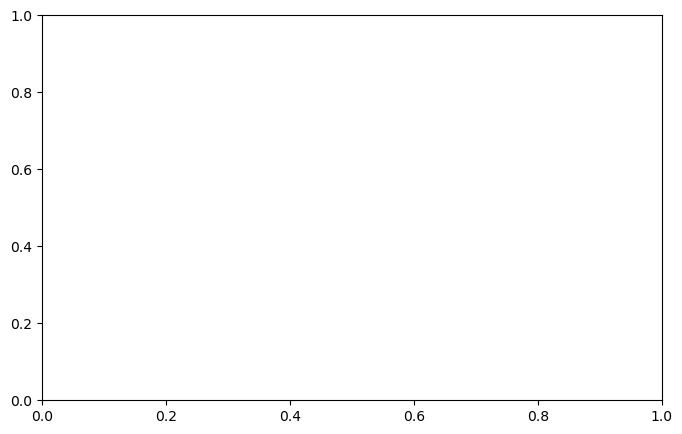

In [12]:
# -------------------------
# 7) plot (Figure 4b-lite)
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.lineplot(
    data=res,
    x="top_n", y="f1", hue="modality",
    estimator="mean", errorbar="sd", marker="o"
)
plt.ylim(0, 0.5)  # Figure 4b 느낌으로 (필요하면 조절)
plt.title(f"{dataset} MoA prediction (MLP) — TopN gene sweep")
plt.xlabel("Top-N genes (ranked)")
plt.ylabel("Weighted F1")
plt.tight_layout()
plt.show()

# (optional) boxplot per topN (Figure 4b 느낌 더 살리기)
plt.figure(figsize=(10,5))
sns.boxplot(data=res, x="top_n", y="f1", hue="modality")
plt.ylim(0, 0.5)
plt.title(f"{dataset} MoA prediction (MLP) — F1 distribution across folds")
plt.xlabel("Top-N genes (ranked)")
plt.ylabel("Weighted F1")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
{}